In [31]:
import os
import cv2
import random
import shutil
from glob import glob
import matplotlib.pyplot as plt
from collections import Counter

In [32]:
# FAR2013 (les dossiers FAR utilisent directement les labels)
far_data_dir = "../../data"  # Chemin vers FAR2013
far_train_dir = os.path.join(far_data_dir, "train")
far_test_dir  = os.path.join(far_data_dir, "test")

# Affectnet7 (les sous-dossiers portent des numéros)
affectnet_data_dir = "../../data2/processed"  # Chemin vers Affectnet7
affectnet_train_dir = os.path.join(affectnet_data_dir, "train")
affectnet_val_dir   = os.path.join(affectnet_data_dir, "val")

# Dossier de sortie fusionné
merged_dir = "merged"
merged_train_dir = os.path.join(merged_dir, "train")
merged_test_dir  = os.path.join(merged_dir, "test")

far_classes = ["neutral", "happy", "sad", "surprise", "fear", "angry"]
affectnet_map = {'0': 'neutral', '1': 'happy', '2': 'sad', '3': 'surprise', '4': 'fear', '6': 'angry'}

# Créer la structure de dossiers de sortie
for split in [merged_train_dir, merged_test_dir]:
    for cls in far_classes:
        os.makedirs(os.path.join(split, cls), exist_ok=True)

In [33]:
def process_far2013_train():
    # Pour chaque classe FAR2013, on sélectionne 4000 images pour le train
    for cls in far_classes:
        src_dir = os.path.join(far_train_dir, cls)
        out_dir = os.path.join(merged_train_dir, cls)
        if not os.path.exists(src_dir):
            print(f"Le dossier {src_dir} n'existe pas.")
            continue
        img_paths = glob(os.path.join(src_dir, "*.*"))
        if len(img_paths) > 4000:
            img_paths = random.sample(img_paths, 4000)
        for img_path in img_paths:
            # Lire l'image en niveaux de gris (FAR2013 est déjà en N&B, généralement 32x32)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            # Redimensionner de 32x32 à 64x64
            img_resized = cv2.resize(img, (64, 64))
            base = os.path.basename(img_path)
            out_path = os.path.join(out_dir, "far_train_" + base)
            cv2.imwrite(out_path, img_resized)

def process_far2013_test():
    # Pour chaque classe FAR2013, on sélectionne 400 images pour le test
    for cls in far_classes:
        src_dir = os.path.join(far_test_dir, cls)
        out_dir = os.path.join(merged_test_dir, cls)
        if not os.path.exists(src_dir):
            print(f"Le dossier {src_dir} n'existe pas.")
            continue
        img_paths = glob(os.path.join(src_dir, "*.*"))
        if len(img_paths) > 400:
            img_paths = random.sample(img_paths, 400)
        for img_path in img_paths:
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img_resized = cv2.resize(img, (64, 64))
            base = os.path.basename(img_path)
            out_path = os.path.join(out_dir, "far_test_" + base)
            cv2.imwrite(out_path, img_resized)


In [34]:
def process_affectnet7_folder(input_dir):
    # Pour chaque dossier (numéro) dans Affectnet7
    for key, label in affectnet_map.items():
        src_dir = os.path.join(input_dir, key)
        if not os.path.exists(src_dir):
            print(f"Le dossier {src_dir} n'existe pas.")
            continue
        out_dir = os.path.join(merged_train_dir, label)
        img_paths = glob(os.path.join(src_dir, "*.*"))
        # Charger le classifieur Haar Cascade pour la détection de visage
        haar_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
        face_cascade = cv2.CascadeClassifier(haar_path)
        for img_path in img_paths:
            img = cv2.imread(img_path)
            if img is None:
                continue
            # Redimensionner à 64x64 (si ce n'est pas déjà le cas)
            img = cv2.resize(img, (64, 64))
            # Convertir en niveaux de gris
            gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
            if len(faces) == 0:
                continue  # Ignorer si aucun visage n'est détecté
            # Prendre le plus grand visage
            faces = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)
            (x, y, w, h) = faces[0]
            face_img = gray[y:y+h, x:x+w]
            face_resized = cv2.resize(face_img, (64, 64))
            base = os.path.basename(img_path)
            out_path = os.path.join(out_dir, "affectnet_" + base)
            cv2.imwrite(out_path, face_resized)

def process_affectnet7():
    process_affectnet7_folder(affectnet_train_dir)
    process_affectnet7_folder(affectnet_val_dir)

In [35]:
print("Traitement FAR2013 train...")
process_far2013_train()
print("Traitement FAR2013 test...")
process_far2013_test()
print("Traitement Affectnet7 train/val...")
process_affectnet7()

print("Preprocessing terminé. Vérifiez le dossier 'merged/' pour la structure fusionnée de train et test.")


Traitement FAR2013 train...
Traitement FAR2013 test...
Traitement Affectnet7 train/val...
Preprocessing terminé. Vérifiez le dossier 'merged/' pour la structure fusionnée de train et test.


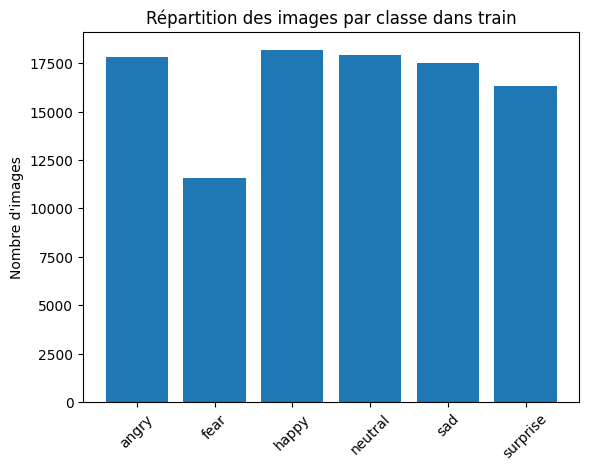

{'angry': 17844, 'fear': 11566, 'happy': 18193, 'neutral': 17953, 'sad': 17508, 'surprise': 16344}


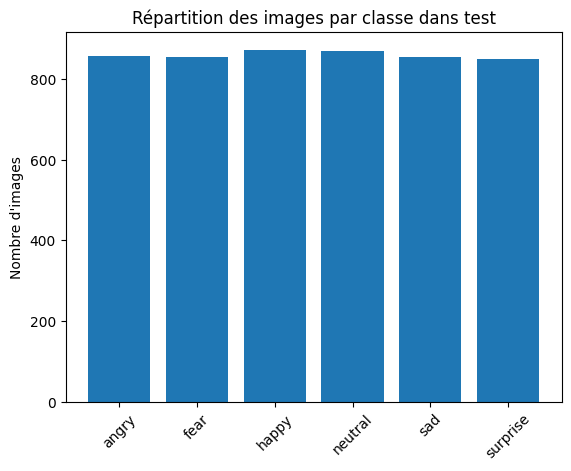

{'angry': 857, 'fear': 854, 'happy': 872, 'neutral': 870, 'sad': 854, 'surprise': 850}


In [40]:
data_path = "./merged/train"
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name))) for class_name in os.listdir(data_path)}

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe dans train")
plt.show()

print(class_counts)

data_path = "./merged/test"
class_counts = {class_name: len(os.listdir(os.path.join(data_path, class_name))) for class_name in os.listdir(data_path)}

plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=45)
plt.ylabel("Nombre d'images")
plt.title("Répartition des images par classe dans test")
plt.show()

print(class_counts)

In [ ]:
# import os
# import cv2
# from glob import glob

# # Chemins
# affectnet_val_dir = "../../data2/processed/val"  # Dossier Affectnet val avec sous-dossiers numériques
# merged_test_dir = "merged/test"             # Dossier de sortie pour le test

# # Mapping des dossiers Affectnet vers les labels
# affectnet_map = {'0': 'neutral', '1': 'happy', '2': 'sad', '3': 'surprise', '4': 'fear', '6': 'angry'}

# # Charger le classifieur Haar Cascade pour la détection de visage
# haar_path = cv2.data.haarcascades + "haarcascade_frontalface_default.xml"
# face_cascade = cv2.CascadeClassifier(haar_path)

# # Créer les dossiers de sortie pour chaque classe dans merged/test
# for label in affectnet_map.values():
#     os.makedirs(os.path.join(merged_test_dir, label), exist_ok=True)

# # Traitement des images de validation d'Affectnet vers merged/test
# for key, label in affectnet_map.items():
#     src_dir = os.path.join(affectnet_val_dir, key)
#     dest_dir = os.path.join(merged_test_dir, label)
    
#     # Vérifier que le dossier source existe
#     if not os.path.exists(src_dir):
#         print(f"Le dossier {src_dir} n'existe pas. Passage au suivant.")
#         continue

#     img_paths = glob(os.path.join(src_dir, "*.*"))
#     for img_path in img_paths:
#         # Lire l'image en couleur
#         img = cv2.imread(img_path)
#         if img is None:
#             continue
#         # Redimensionner à 64x64 (au cas où)
#         img = cv2.resize(img, (64, 64))
#         # Conversion en niveaux de gris
#         gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#         # Détection de visage
#         faces = face_cascade.detectMultiScale(gray, scaleFactor=1.1, minNeighbors=5)
#         if len(faces) == 0:
#             continue  # Ignorer si aucun visage n'est détecté
#         # Choisir le plus grand visage détecté
#         faces = sorted(faces, key=lambda f: f[2]*f[3], reverse=True)
#         (x, y, w, h) = faces[0]
#         face_crop = gray[y:y+h, x:x+w]
#         # Redimensionner le visage en 64x64
#         face_resized = cv2.resize(face_crop, (64, 64))
#         # Construire le nom de fichier de sortie
#         base = os.path.basename(img_path)
#         out_filename = "affectnet_val_" + base
#         out_path = os.path.join(dest_dir, out_filename)
#         cv2.imwrite(out_path, face_resized)

# print("Traitement des images Affectnet val vers merged/test terminé.")


Traitement des images Affectnet val vers merged/test terminé.
